In [1]:
# Import and load

import keras
keras.__version__

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint

import os

from sklearn.metrics import roc_auc_score 

import matplotlib.pyplot as plt 
%matplotlib inline

from matplotlib2tikz import save as tikz_save

n_unique_words = 10000 
max_review_length = 500

print('Loading data...')
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip
pad_type = trunc_type = 'pre'
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

print(len(x_train), 'training sequences')
print(len(x_valid), 'validation sequences')
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)



Using TensorFlow backend.


Loading data...
(25000, 'training sequences')
(25000, 'validation sequences')
('x_train shape:', (25000, 500))
('x_valid shape:', (25000, 500))


In [13]:
# training:
epochs = 5
batch_size = 128

# vector-space embedding: 
n_dim = 32

# RNN layer architecture:
n_rnn = 32 
drop_rnn = 0.2

model1 = Sequential()
model1.add(layers.Embedding(n_unique_words, n_dim))
model1.add(layers.LSTM(n_rnn, dropout=drop_rnn, recurrent_dropout=0.2))
model1.add(layers.Dense(1, activation='sigmoid')) 

model2 = Sequential()
model2.add(layers.Embedding(n_unique_words, n_dim))
model2.add(layers.LSTM(2*n_rnn, dropout=drop_rnn, recurrent_dropout=0.2))
model2.add(layers.Dense(1, activation='sigmoid')) 

model3 = Sequential()
model3.add(layers.Embedding(n_unique_words, n_dim))
model3.add(layers.LSTM(n_rnn, dropout=drop_rnn, recurrent_dropout=0.2, return_sequences=True))
model3.add(layers.LSTM(n_rnn, dropout=drop_rnn, recurrent_dropout=0.2))
model3.add(layers.Dense(1, activation='sigmoid')) 

model4 = Sequential()
model4.add(layers.Embedding(n_unique_words, n_dim))
model4.add(layers.LSTM(2*n_rnn, dropout=drop_rnn, recurrent_dropout=0.2, return_sequences=True))
model4.add(layers.LSTM(2*n_rnn, dropout=drop_rnn, recurrent_dropout=0.2))
model4.add(layers.Dense(1, activation='sigmoid')) 

# output directory name:
models = [model1, model2, model3, model4]
outdirs =  ['model_output/lstm1',
            'model_output/lstm2',
            'model_output/lstm3',
            'model_output/lstm4']


In [ ]:
def train_model(model, output_dir):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])
    return history

hists = []
for k in range(len(models)):
    hists.append(train_model(models[k], outdirs[k]))
    print('Training model {} complete'.format(k))
    

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 83s 3ms/step - loss: 0.5356 - acc: 0.7282 - val_loss: 0.3976 - val_acc: 0.8269
Epoch 2/5
25000/25000 [==============================] - 82s 3ms/step - loss: 0.3715 - acc: 0.8430 - val_loss: 0.3782 - val_acc: 0.8365
Epoch 3/5
21120/25000 [========================>.....] - ETA: 10s - loss: 0.3281 - acc: 0.8670

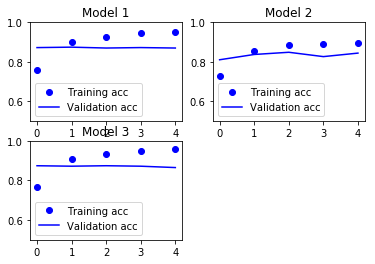

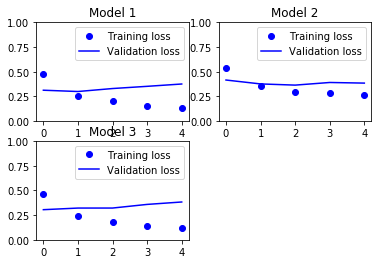

In [12]:
plt.figure(1)
plt.clf()
plt.figure(2)
plt.clf()

for k in range(len(models)):
    
    history = hists[k]

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    
    plt.figure(1)
    plt.subplot(2, 2, k+1)
    plt.title('Model {}'.format(k+1))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.ylim([0.5, 1])
    #plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(2)
    plt.subplot(2, 2, k+1)
    plt.title('Model {}'.format(k+1))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.title('Training and validation loss')
    plt.ylim([0, 1])
    plt.legend()

plt.show()

In [14]:
y_hats = []
points = ['1', '2', '1']
for k in range(len(models)):
    models[k].load_weights(outdirs[k]+"/weights.0"+points[k]+".hdf5") # zero-indexed
    y_hats.append(models[k].predict_proba(x_valid))
    print("Model {}: {:0.2f}".format(k+1, roc_auc_score(y_valid, y_hats[k])*100.0))
    

Model 1: 94.50
Model 2: 91.91
Model 3: 94.62


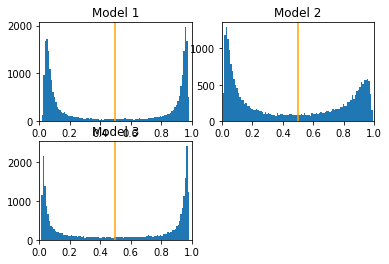

In [15]:
plt.figure(2)
plt.clf()
for k in range(len(models)):
    plt.subplot(2, 2, k+1)
    plt.title('Model {}'.format(k+1))
    plt.hist(y_hats[k], bins=100)
    _ = plt.axvline(x=0.5, color='orange')
    plt.xlim([0, 1])